In [6]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, AutoModelForQuestionAnswering, AutoTokenizer
import os
import re
import string
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import import_ipynb
import extract_transform_evaluate as fn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train_model(self, dataloader, optimizer):
    self.train()
    accuracy_arr, loss_arr = [], []
    for batch in tqdm(dataloader, desc='Training Started!'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(self.device)
        attention_mask = batch['attention_mask'].to(self.device)
        start_pos = batch['start_positions'].to(self.device)
        end_pos = batch['end_positions'].to(self.device)
        start_res, end_res = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = self.find_focal_loss(start_res, end_res, start_pos, end_pos)
        loss_arr.append(loss.item())
        loss.backward()
        optimizer.step()

        start_pred = torch.argmax(start_res, dim=1)
        end_pred = torch.argmax(end_res, dim=1)

        accuracy_arr.append(((start_pred == start_pos).sum()/len(start_pred)).item())
        accuracy_arr.append(((end_pred == end_pos).sum()/len(end_pred)).item())

    return sum(accuracy_arr)/len(accuracy_arr), sum(loss_arr)/len(loss_arr)

def plot_metrics(epochs, train_losses, train_accuracies, wer_scores, f1_scores):
    metrics = {
        'Training Loss': train_losses,
        'Training Accuracy': train_accuracies,
        'Word Error Rate (WER)': wer_scores,
        'F1 Score': f1_scores
    }

    colors = ['blue','green','red','brown']
    plt.figure(figsize=(12, 8))
    
    for i, (title, values) in enumerate(metrics.items(), start=1):
        plt.subplot(2, 2, i)
        plt.plot(epochs, values, marker='o', linestyle='-', color=colors[i-1])
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(title.split()[1])
    
    plt.tight_layout()
    plt.show()

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch - 1


Training Started!: 100%|██████████| 2320/2320 [13:06<00:00,  2.95it/s]


Train Accuracy: 0.465615378705592 and Train Loss: 1.824924897543829


Evaluating Model!: 100%|██████████| 15875/15875 [02:28<00:00, 106.68it/s]


F1 Score: 0.6616622717533911 and WER Score: 1.099821713776325
Epoch - 2


Training Started!: 100%|██████████| 2320/2320 [13:07<00:00,  2.95it/s]


Train Accuracy: 0.6553032635614789 and Train Loss: 0.9282096131351487


Evaluating Model!: 100%|██████████| 15875/15875 [02:28<00:00, 106.77it/s]


F1 Score: 0.6818516523268792 and WER Score: 0.9468112766036474
Epoch - 3


Training Started!: 100%|██████████| 2320/2320 [13:07<00:00,  2.95it/s]


Train Accuracy: 0.7496478602418611 and Train Loss: 0.576625158117506


Evaluating Model!: 100%|██████████| 15875/15875 [02:28<00:00, 106.75it/s]


F1 Score: 0.6830784754219114 and WER Score: 0.8433309809456598
Epoch - 4


Training Started!: 100%|██████████| 2320/2320 [13:07<00:00,  2.95it/s]


Train Accuracy: 0.8171605603448275 and Train Loss: 0.3701790762744073


Evaluating Model!: 100%|██████████| 15875/15875 [02:28<00:00, 106.60it/s]


F1 Score: 0.681778506733307 and WER Score: 0.8718010622887494
Epoch - 5


Training Started!: 100%|██████████| 2320/2320 [13:07<00:00,  2.95it/s]


Train Accuracy: 0.8626674107179559 and Train Loss: 0.2557489826343954


Evaluating Model!: 100%|██████████| 15875/15875 [02:28<00:00, 106.64it/s]


F1 Score: 0.6861077841820087 and WER Score: 0.8475652787579393
Epoch - 6


Training Started!: 100%|██████████| 2320/2320 [13:07<00:00,  2.94it/s]


Train Accuracy: 0.8934228756304445 and Train Loss: 0.18809053381776503


Evaluating Model!: 100%|██████████| 15875/15875 [02:28<00:00, 106.67it/s]


F1 Score: 0.6790747175431399 and WER Score: 0.9447126991791405


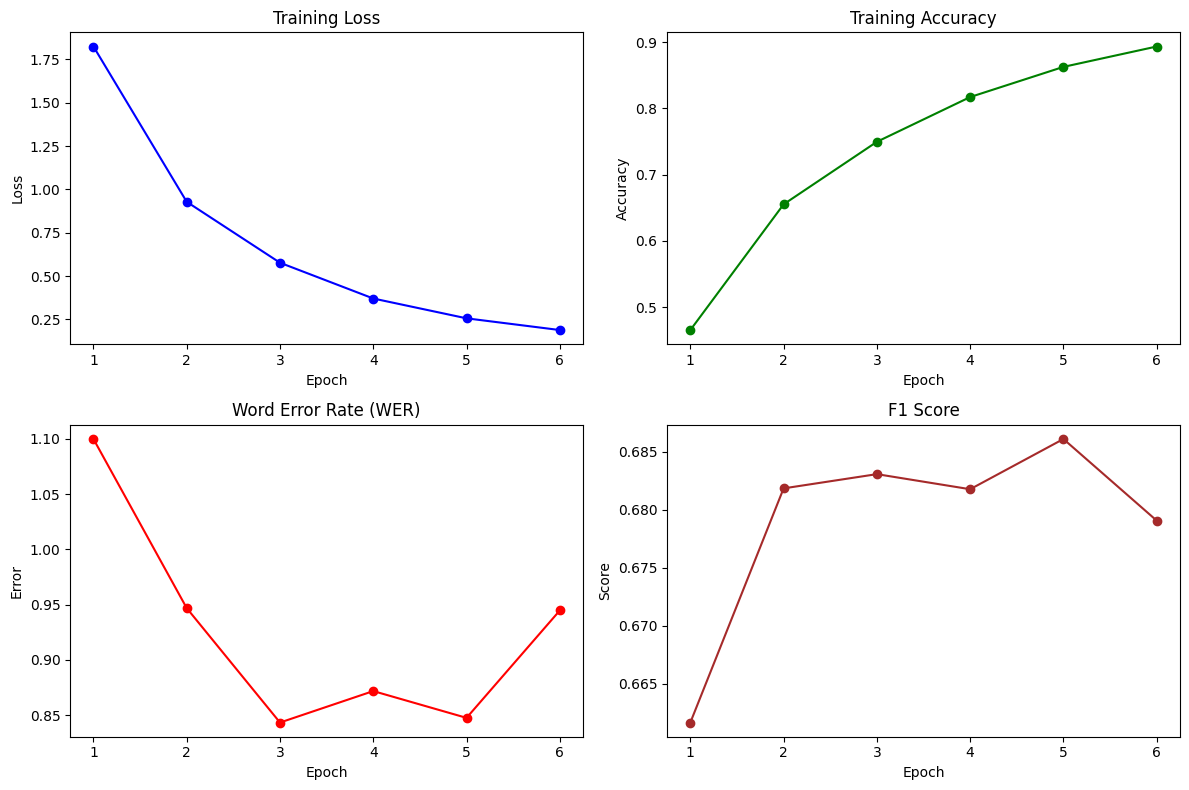

In [7]:
train_data = '../spoken_train-v1.1.json'
test_data = '../spoken_test-v1.1.json'
MODEL_PATH = "bert-base-uncased"
MODEL_SAVE_PATH = "qa_simple_model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

train_encodings = fn.collect_and_find_positions(train_data, tokenizer, 512)
test_encodings = fn.collect_and_find_positions(test_data, tokenizer, 512)

train_set = fn.SpokenSquad(train_encodings)
test_set = fn.SpokenSquad(test_encodings)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1)

bert_base_uncased_model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH)
qa_model = fn.QAModel(bert_base_uncased_model, device)
optimizer = AdamW(qa_model.parameters(), lr=2e-5, weight_decay=0.02)

wer_scores, accuracies, losses, f1_scores  = [], [], [], []

epoch = 0
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

while epoch < 6:
    print(f'Epoch - {epoch + 1}')
    
    accuracy, loss = train_model(qa_model, train_loader, optimizer)
    accuracies.append(accuracy)
    losses.append(loss)
    print(f"Train Accuracy: {accuracy} and Train Loss: {loss}")

    avg_f1_score, wer_score = qa_model.evaluate_model(test_loader, tokenizer)
    f1_scores.append(avg_f1_score)
    wer_scores.append(wer_score)
    print(f"F1 Score: {avg_f1_score} and WER Score: {wer_score}")

    epoch += 1

torch.save(qa_model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'model_weights.pt'))
tokenizer.save_pretrained(MODEL_SAVE_PATH)

plot_metrics(range(1, 7), losses, accuracies, wer_scores, f1_scores) 